In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/exercise-recognition/3d_distances.csv
/kaggle/input/exercise-recognition/xyz_distances.csv
/kaggle/input/exercise-recognition/angles.csv
/kaggle/input/exercise-recognition/landmarks.csv
/kaggle/input/exercise-recognition/labels.csv


In [32]:
import pandas as pd
import numpy as np
import warnings

# Importing models from sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import joblib


from xgboost import XGBClassifier


# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(42)
warnings.filterwarnings('ignore')

In [33]:
# Bring in the data
df = pd.read_csv('/kaggle/input/exercise-recognition/landmarks.csv')

# Load labels
df_labels = pd.read_csv('/kaggle/input/exercise-recognition/labels.csv')
df = pd.merge(df, df_labels, on='pose_id')

df.head()

,pose_id,x_nose,y_nose,z_nose,x_left_eye_inner,y_left_eye_inner,z_left_eye_inner,x_left_eye,y_left_eye,z_left_eye,...,x_right_heel,y_right_heel,z_right_heel,x_left_foot_index,y_left_foot_index,z_left_foot_index,x_right_foot_index,y_right_foot_index,z_right_foot_index,pose
0,0,-5.889507,-57.637520,-45.019750,-4.656085,-62.832863,-44.571823,-3.302626,-63.386856,-44.567863,...,-0.842025,35.037060,50.565020,5.842190,45.971020,50.263714,0.092779,45.842150,41.427795,jumping_jacks_down
1,1,-4.255504,-62.935925,-128.907500,-2.977403,-67.035990,-124.258545,-2.215265,-67.198250,-124.263240,...,-1.298891,54.733307,-6.886051,3.980098,65.370830,-49.023930,-5.090634,65.641780,-42.878056,jumping_jacks_down
2,2,-2.878917,-61.709988,-137.453340,-1.619050,-65.693750,-132.181660,-0.785822,-65.814340,-132.184070,...,-2.119770,51.265694,-15.554097,1.994894,62.725025,-57.717957,-4.452602,62.494457,-53.804527,jumping_jacks_down
3,3,-4.242575,-60.371220,-135.094830,-3.118133,-64.416000,-129.995930,-2.369744,-64.603290,-130.003400,...,-1.485475,59.729427,1.433403,1.950102,68.187256,-42.989098,-4.573338,68.144350,-34.117043,jumping_jacks_down
4,4,-0.805543,-56.178570,-41.124413,-0.055174,-58.501305,-37.938560,0.456936,-58.473960,-37.954430,...,-2.455719,52.861732,45.936783,2.699764,57.254112,27.531416,-2.288348,57.803005,26.288315,jumping_jacks_down


In [34]:
# Sorting the null values
df.isnull().sum().sort_values(ascending=False)

pose_id           0
x_left_thumb_2    0
y_right_hip       0
x_right_hip       0
z_left_hip        0
                 ..
x_mouth_right     0
z_mouth_left      0
y_mouth_left      0
x_mouth_left      0
pose              0
Length: 101, dtype: int64

In [35]:
# couting the values in pose
df['pose'].value_counts()

jumping_jacks_down    189
jumping_jacks_up      181
pullups_down          154
pushups_up            144
squats_up             139
pullups_up            135
squats_down           127
pushups_down          102
situp_down            102
situp_up               99
Name: pose, dtype: int64

In [36]:
# creating labels for groups of poses

# Creating a new column for the groups
df['exercise'] = np.nan

# If the pose contains the word 'squat' then the exercise is squats
df.loc[df['pose'].str.contains('squat'), 'exercise'] = 'squats'
df.loc[df['pose'].str.contains('jumping_jacks'), 'exercise'] = 'jumping jacks'
df.loc[df['pose'].str.contains('push_up'), 'exercise'] = 'push ups'
df.loc[df['pose'].str.contains('situp'), 'exercise'] = 'sit ups'
df.loc[df['pose'].str.contains('pullups'), 'exercise'] = 'pull ups'
# Checking the new column
df.head()

,pose_id,x_nose,y_nose,z_nose,x_left_eye_inner,y_left_eye_inner,z_left_eye_inner,x_left_eye,y_left_eye,z_left_eye,...,y_right_heel,z_right_heel,x_left_foot_index,y_left_foot_index,z_left_foot_index,x_right_foot_index,y_right_foot_index,z_right_foot_index,pose,exercise
0,0,-5.889507,-57.637520,-45.019750,-4.656085,-62.832863,-44.571823,-3.302626,-63.386856,-44.567863,...,35.037060,50.565020,5.842190,45.971020,50.263714,0.092779,45.842150,41.427795,jumping_jacks_down,jumping jacks
1,1,-4.255504,-62.935925,-128.907500,-2.977403,-67.035990,-124.258545,-2.215265,-67.198250,-124.263240,...,54.733307,-6.886051,3.980098,65.370830,-49.023930,-5.090634,65.641780,-42.878056,jumping_jacks_down,jumping jacks
2,2,-2.878917,-61.709988,-137.453340,-1.619050,-65.693750,-132.181660,-0.785822,-65.814340,-132.184070,...,51.265694,-15.554097,1.994894,62.725025,-57.717957,-4.452602,62.494457,-53.804527,jumping_jacks_down,jumping jacks
3,3,-4.242575,-60.371220,-135.094830,-3.118133,-64.416000,-129.995930,-2.369744,-64.603290,-130.003400,...,59.729427,1.433403,1.950102,68.187256,-42.989098,-4.573338,68.144350,-34.117043,jumping_jacks_down,jumping jacks
4,4,-0.805543,-56.178570,-41.124413,-0.055174,-58.501305,-37.938560,0.456936,-58.473960,-37.954430,...,52.861732,45.936783,2.699764,57.254112,27.531416,-2.288348,57.803005,26.288315,jumping_jacks_down,jumping jacks


In [37]:
# Counting the values of exercise
df['exercise'].value_counts()

jumping jacks    370
pull ups         289
squats           266
sit ups          201
Name: exercise, dtype: int64

In [38]:
''' Creating a function that gets the data and cleans it for modeling'''

def get_data():
    # Bring in the data
    data = df[0:1097]
    # Drop pose_id column
    data.drop('pose_id', axis=1, inplace=True)
    # Creating a new column for the groups
    data['exercise'] = np.nan
    # If the pose contains the word 'squat' then the exercise is squats
    data.loc[data['pose'].str.contains('squat'), 'exercise'] = 'squats'
    data.loc[data['pose'].str.contains('jumping_jacks'), 'exercise'] = 'jumping jacks'
    data.loc[data['pose'].str.contains('pushup'), 'exercise'] = 'push ups'
    data.loc[data['pose'].str.contains('situp'), 'exercise'] = 'sit ups'
    data.loc[data['pose'].str.contains('pullups'), 'exercise'] = 'pull ups'
    # Dropping pose column
    data.drop('pose', axis=1, inplace=True)

    # going to use LabelEncoder to encode the exercise column
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    print(data['exercise'].unique())
    data['exercise'] = le.fit_transform(data['exercise'])
    print(data['exercise'].unique())
    
    return data

['jumping jacks' 'pull ups' 'push ups' 'sit ups']
[0 1 2 3]
The accuracy score is:  0.8772727272727273
The confusion matrix is:  [[74  6  0  0]
 [ 6 42  1  4]
 [ 0  0 47  0]
 [ 2  6  2 30]]
The classification report is:                precision    recall  f1-score   support

           0       0.90      0.93      0.91        80
           1       0.78      0.79      0.79        53
           2       0.94      1.00      0.97        47
           3       0.88      0.75      0.81        40

    accuracy                           0.88       220
   macro avg       0.88      0.87      0.87       220
weighted avg       0.88      0.88      0.88       220

        x_nose     y_nose      z_nose  x_left_eye_inner  y_left_eye_inner  \
44    1.081342 -59.426697  -50.718075          2.313979        -61.512905   
568  -3.347696 -64.293340  -38.162280         -4.696597        -67.100180   
56    0.018575 -59.233646  -40.493763          0.314540        -61.950540   
636   2.794856 -55.466694   -4.92503

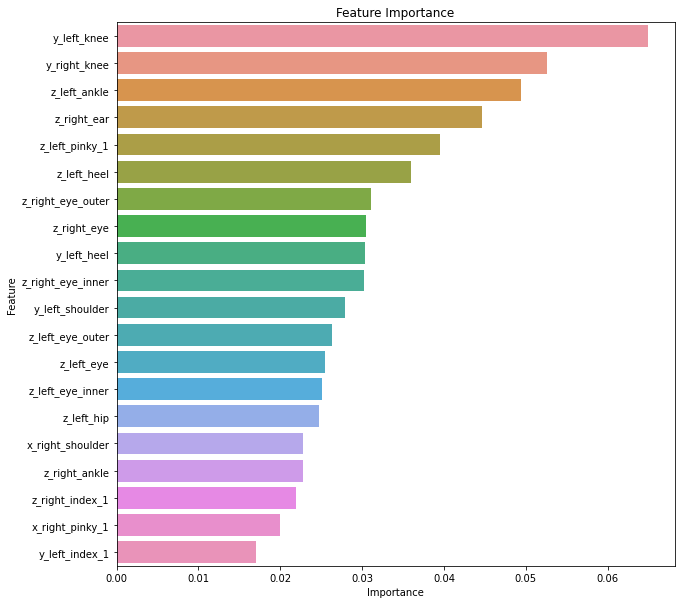

In [39]:
'''Creating a function that fit a Logistic Regression model and see the accuracy feature importance'''

def log_reg():
    # Getting the data
    df = get_data()
    # Splitting the data into X and y
    X = df.drop('exercise', axis=1)
    y = df['exercise']
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Creating a Logistic Regression model
    log_reg = LogisticRegression()
    # Fitting the model
    log_reg.fit(X_train, y_train)
    # Save model
    joblib.dump(log_reg, '/kaggle/working/log_reg.pkl')
    # Getting the accuracy score
    print('The accuracy score is: ', accuracy_score(y_test, log_reg.predict(X_test)))
    # Creating a confusion matrix
    print('The confusion matrix is: ', confusion_matrix(y_test, log_reg.predict(X_test)))
    # Creating a classification report
    print('The classification report is: ', classification_report(y_test, log_reg.predict(X_test)))
    print(X_test, y_test)

    # Putting the feature importance into a dataframe
    feature_importance = pd.DataFrame(log_reg.coef_, columns=X.columns)
    
    # Sorting the values to include top 20
    feature_importance = feature_importance.T.sort_values(by=0, ascending=False).head(20)

    # Plotting the feature importance
    plt.figure(figsize=(10, 10))
    sns.barplot(x=feature_importance[0], y=feature_importance.index)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
    
log_reg()

['jumping jacks' 'pull ups' 'push ups' 'sit ups']
[0 1 2 3]
The accuracy score is:  0.8590909090909091
The confusion matrix is:  [[69 10  0  1]
 [ 6 41  1  5]
 [ 1  2 44  0]
 [ 1  3  1 35]]
The classification report is:                precision    recall  f1-score   support

           0       0.90      0.86      0.88        80
           1       0.73      0.77      0.75        53
           2       0.96      0.94      0.95        47
           3       0.85      0.88      0.86        40

    accuracy                           0.86       220
   macro avg       0.86      0.86      0.86       220
weighted avg       0.86      0.86      0.86       220



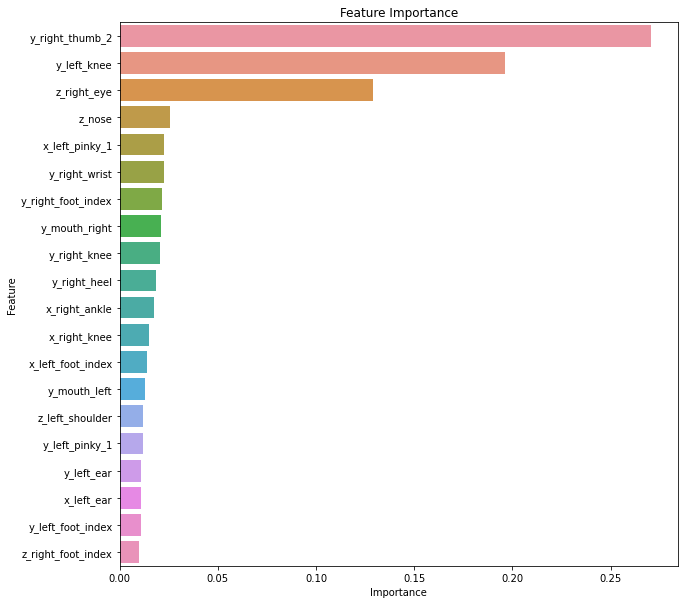

In [40]:
''' Now fitting a decision tree model and seeing the accuracy and feature importance'''

def decision_tree():
    # Getting the data
    df = get_data()
    # Splitting the data into X and y
    X = df.drop('exercise', axis=1)
    y = df['exercise']
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Creating a Decision Tree model
    decision_tree = DecisionTreeClassifier()
    # Fitting the model
    decision_tree.fit(X_train, y_train)
    # Save model
    joblib.dump(decision_tree, '/kaggle/working/decision_tree.pkl')
    # Getting the accuracy score
    print('The accuracy score is: ', accuracy_score(y_test, decision_tree.predict(X_test)))
    # Creating a confusion matrix
    print('The confusion matrix is: ', confusion_matrix(y_test, decision_tree.predict(X_test)))
    # Creating a classification report
    print('The classification report is: ', classification_report(y_test, decision_tree.predict(X_test)))


    # Putting the feature importance into a dataframe
    feature_importance = pd.DataFrame(decision_tree.feature_importances_, index=X.columns, columns=['Importance'])
    
    # Sorting the values to include top 20
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(20)

    # Plotting the feature importance
    plt.figure(figsize=(10, 10))
    sns.barplot(x=feature_importance['Importance'], y=feature_importance.index)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
    
decision_tree()

['jumping jacks' 'pull ups' 'push ups' 'sit ups']
[0 1 2 3]
The accuracy score is:  0.9045454545454545
The confusion matrix is:  [[71  8  0  1]
 [ 3 47  1  2]
 [ 0  1 45  1]
 [ 1  2  1 36]]
The classification report is:                precision    recall  f1-score   support

           0       0.95      0.89      0.92        80
           1       0.81      0.89      0.85        53
           2       0.96      0.96      0.96        47
           3       0.90      0.90      0.90        40

    accuracy                           0.90       220
   macro avg       0.90      0.91      0.91       220
weighted avg       0.91      0.90      0.91       220



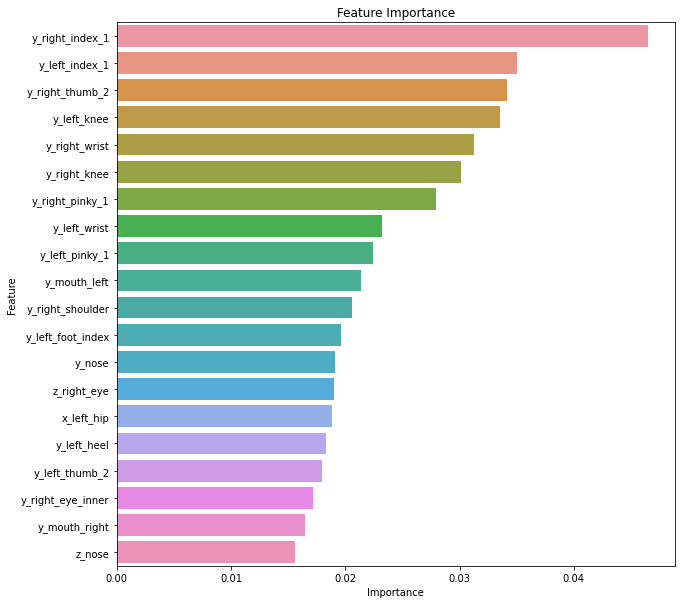

In [41]:
''' Now fitting a random forest model and seeing the accuracy and feature importance'''

def random_forest():
    # Getting the data
    df = get_data()
    # Splitting the data into X and y
    X = df.drop('exercise', axis=1)
    y = df['exercise']
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Creating a Random Forest model
    random_forest = RandomForestClassifier()
    # Fitting the model
    random_forest.fit(X_train, y_train)
    # Save model
    joblib.dump(random_forest, '/kaggle/working/random_forest.pkl')
    # Getting the accuracy score
    print('The accuracy score is: ', accuracy_score(y_test, random_forest.predict(X_test)))
    # Creating a confusion matrix
    print('The confusion matrix is: ', confusion_matrix(y_test, random_forest.predict(X_test)))
    # Creating a classification report
    print('The classification report is: ', classification_report(y_test, random_forest.predict(X_test)))


    # Putting the feature importance into a dataframe
    feature_importance = pd.DataFrame(random_forest.feature_importances_, index=X.columns, columns=['Importance'])
    
    # Sorting the values to include top 20
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(20)

    # Plotting the feature importance
    plt.figure(figsize=(10, 10))
    sns.barplot(x=feature_importance['Importance'], y=feature_importance.index)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()


random_forest()

['jumping jacks' 'pull ups' 'push ups' 'sit ups']
[0 1 2 3]
The accuracy score is:  0.9227272727272727
The confusion matrix is:  [[74  6  0  0]
 [ 4 45  0  4]
 [ 0  1 46  0]
 [ 0  1  1 38]]
The classification report is:                precision    recall  f1-score   support

           0       0.95      0.93      0.94        80
           1       0.85      0.85      0.85        53
           2       0.98      0.98      0.98        47
           3       0.90      0.95      0.93        40

    accuracy                           0.92       220
   macro avg       0.92      0.93      0.92       220
weighted avg       0.92      0.92      0.92       220



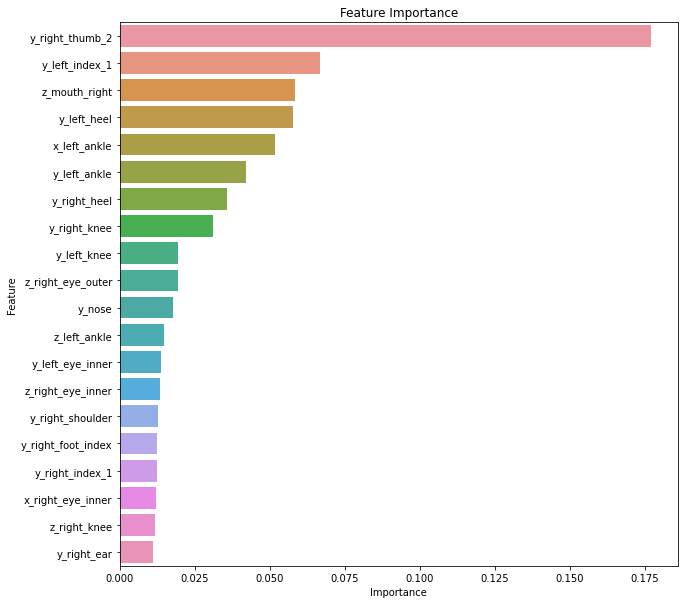

In [42]:
''' Creating a function that fit a XGBoost model and see the accuracy feature importance'''

def xg_boost():
    # Getting the data
    df = get_data()
    # Splitting the data into X and y
    X = df.drop('exercise', axis=1)
    y = df['exercise']
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Creating a XGBoost model
    xg_boost = XGBClassifier()
    # Fitting the model
    xg_boost.fit(X_train, y_train)
    # Save model
    joblib.dump(xg_boost, '/kaggle/working/xg_boost.pkl')
    # Getting the accuracy score
    print('The accuracy score is: ', accuracy_score(y_test, xg_boost.predict(X_test)))
    # Creating a confusion matrix
    print('The confusion matrix is: ', confusion_matrix(y_test, xg_boost.predict(X_test)))
    # Creating a classification report
    print('The classification report is: ', classification_report(y_test, xg_boost.predict(X_test)))


    # Putting the feature importance into a dataframe
    feature_importance = pd.DataFrame(xg_boost.feature_importances_, index=X.columns, columns=['Importance'])
    
    # Sorting the values to include top 20
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(20)

    # Plotting the feature importance
    plt.figure(figsize=(10, 10))
    sns.barplot(x=feature_importance['Importance'], y=feature_importance.index)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

xg_boost()

In [43]:
''' Going to fit a XG Boost on all the data'''

def fit_xg_boost_classifier_all_data():
    # Setting random seed
    np.random.seed(42)

    df = get_data()

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(df.drop('exercise', axis=1), df['exercise'], test_size=0.2)


    # Creating a XGBClassifier object

    xgb = XGBClassifier(random_state=42)

    # Fitting the model
    xgb.fit(X_train, y_train)

    # Scoring the model
    score = xgb.score(X_test, y_test)

    # Getting the roc_auc_score
    roc_auc = roc_auc_score(y_test, xgb.predict_proba(X_test), average = 'macro', multi_class = 'ovr')

    print(f'accuracy_score: {score}')

    return roc_auc

fit_xg_boost_classifier_all_data()

['jumping jacks' 'pull ups' 'push ups' 'sit ups']
[0 1 2 3]
accuracy_score: 0.9227272727272727


0.9882729165018393

In [44]:
''' Going to fit the Logistic Regression model & get top 10 feature importances, but this time I will scale the data
    using StandardScaler() before fitting the model. '''

def fit_logistic_regression_scaled():
    # Setting random seed
    np.random.seed(42)

    df = get_data()

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(df.drop('exercise', axis=1), df['exercise'], test_size=0.2)

    # Scaling the data
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Creating a logistic regression object
    lr = LogisticRegression(random_state=42)

    # Fitting the model
    lr.fit(X_train_sc, y_train)

    # Scoring the model
    score = lr.score(X_test, y_test)

    # getting the top 10 feature importances from the logistic regression model
    feature_importances = lr.coef_[0]

    # Creating a dictionary of feature importances
    feature_dict = dict(zip(X_train.columns, feature_importances))

    # Sorting the dictionary
    sorted_dict = dict(sorted(feature_dict.items(), key=lambda x: x[1], reverse=True))

    # Getting the top features
    top_features_lr = list(sorted_dict.items())[:70]

    return score, top_features_lr

In [45]:
''' Going to fit a GradientBoostingClassifier model & get top 10 feature importances'''

def fit_gradient_boosting_classifier():
    # Setting random seed
    np.random.seed(42)

    df = get_data()

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(df.drop('exercise', axis=1), df['exercise'], test_size=0.2)

    # Creating a GradientBoostingClassifier object
    gbc = GradientBoostingClassifier(random_state=42)

    # Fitting the model
    gbc.fit(X_train, y_train)

    # Scoring the model
    score = gbc.score(X_test, y_test)

    # getting the top 10 feature importances from the logistic regression model
    feature_importances = gbc.feature_importances_

    # Creating a dictionary of feature importances
    feature_dict = dict(zip(X_train.columns, feature_importances))

    # Sorting the dictionary
    sorted_dict = dict(sorted(feature_dict.items(), key=lambda x: x[1], reverse=True))

    # Getting the top features
    top_features_gbc = list(sorted_dict.items())[:70]

    return score, top_features_gbc

In [46]:
''' Creating a function that will fit a RandomForestClassifier model and get the top 10 feature importances'''

def fit_random_forest_classifier():
    # Setting random seed
    np.random.seed(42)

    df = get_data()

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(df.drop('exercise', axis=1), df['exercise'], test_size=0.2)

    # Creating a RandomForestClassifier object
    rfc = RandomForestClassifier(random_state=42)

    # Fitting the model
    rfc.fit(X_train, y_train)

    # Scoring the model
    score = rfc.score(X_test, y_test)

    # getting the top 10 feature importances from the logistic regression model
    feature_importances = rfc.feature_importances_

    # Creating a dictionary of feature importances
    feature_dict = dict(zip(X_train.columns, feature_importances))

    # Sorting the dictionary
    sorted_dict = dict(sorted(feature_dict.items(), key=lambda x: x[1], reverse=True))

    # Getting the top features
    top_features_rfc = list(sorted_dict.items())[:70]

    return score, top_features_rfc

In [47]:
''' Creating a function that will fit a XGBClassifier model and get the top 10 feature importances'''

def fit_xg_boost_classifier():
    # Setting random seed
    np.random.seed(42)

    df = get_data()

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(df.drop('exercise', axis=1), df['exercise'], test_size=0.2)

    # Creating a XGBClassifier object
    xgb = XGBClassifier(random_state=42)

    # Fitting the model
    xgb.fit(X_train, y_train)
    
    # Save model
    joblib.dump(xgb, '/kaggle/working/xgb.pkl')

    # Scoring the model
    score = xgb.score(X_test, y_test)

    # getting the top 10 feature importances from the logistic regression model
    feature_importances = xgb.feature_importances_

    # Creating a dictionary of feature importances
    feature_dict = dict(zip(X_train.columns, feature_importances))

    # Sorting the dictionary
    sorted_dict = dict(sorted(feature_dict.items(), key=lambda x: x[1], reverse=True))

    # Getting the top features
    top_features_xgb = list(sorted_dict.items())[:70]

    return score, top_features_xgb

In [48]:
''' creating a function that will now fit these models to the data and get the top 10 features from each model and adding keys to a list'''

def get_top_features():
    

    # Getting the top features from the Logistic Regression model
    score_lr, top_features_lr = fit_logistic_regression_scaled()


    # Getting the top features from the GradientBoostingClassifier model
    score_gbc, top_features_gbc = fit_gradient_boosting_classifier()


    # Getting the top features from the RandomForestClassifier model
    score_rfc, top_features_rfc = fit_random_forest_classifier()


    # Getting the top features from the XGBClassifier model
    score_xgb, top_features_xgb = fit_xg_boost_classifier()

    top_features = []
    for i in range(70):
        top_features.append(top_features_lr[i][0])
        top_features.append(top_features_gbc[i][0])
        top_features.append(top_features_rfc[i][0])
        top_features.append(top_features_xgb[i][0])

    # Getting unique features
    top_features = list(set(top_features))


    return top_features

In [49]:
''' Not going to fit a XGBClassifier model and will incrementally add the top features from the top_features list to see how roc_auc_score changes'''

def fit_xg_boost_classifier_incremental():
    # Setting random seed
    np.random.seed(42)

    df = get_data()

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(df.drop('exercise', axis=1), df['exercise'], test_size=0.2)

    features = get_top_features()

    # Creating a XGBClassifier object

    xgb = XGBClassifier(random_state=42)

    # Creating a list to store the roc_auc_score
    roc_auc_scores = []

    # Creating a list to store the features
    feature_list = []

    # Looping through the top features
    for feature in features:
        # Adding the feature to the feature list
        feature_list.append(feature)

        # Fitting the model
        xgb.fit(X_train[feature_list], y_train)

        # Scoring the model
        score = xgb.score(X_test[feature_list], y_test)

        # Getting the roc_auc_score
        roc_auc = roc_auc_score(y_test, xgb.predict_proba(X_test[feature_list]), average = 'macro', multi_class = 'ovr')

        # Adding the score to the list if there is no score or if the score is greater than the previous score
        if len(roc_auc_scores) == 0 or roc_auc > roc_auc_scores[-1]:

            # Appending the roc_auc_score to the roc_auc_scores list
            roc_auc_scores.append(roc_auc)
        else:
            # Removing the feature from the feature list
            feature_list.remove(feature)

 
    # Creating a dictionary of the feature list and the roc_auc_score
    feature_dict = dict(zip(feature_list, roc_auc_scores))

    # Sorting the dictionary
    sorted_dict = dict(sorted(feature_dict.items(), key=lambda x: x[1], reverse=True))

    # Getting the top features
    top_features_xgb = list(sorted_dict.items())[:70]

    print("{0:.3f}".format(score))

    return top_features_xgb

In [50]:
fit_xg_boost_classifier_incremental()

['jumping jacks' 'pull ups' 'push ups' 'sit ups']
[0 1 2 3]
['jumping jacks' 'pull ups' 'push ups' 'sit ups']
[0 1 2 3]
['jumping jacks' 'pull ups' 'push ups' 'sit ups']
[0 1 2 3]
['jumping jacks' 'pull ups' 'push ups' 'sit ups']
[0 1 2 3]
['jumping jacks' 'pull ups' 'push ups' 'sit ups']
[0 1 2 3]
0.936


[('z_right_foot_index', 0.9933827880099463),
 ('z_left_ankle', 0.9928965502428927),
 ('x_left_shoulder', 0.9927077312718727),
 ('x_left_foot_index', 0.9924691413589535),
 ('z_right_knee', 0.9912991166506098),
 ('y_right_heel', 0.9911967506279382),
 ('y_left_thumb_2', 0.9911955657554719),
 ('y_left_knee', 0.9897197810376714),
 ('x_nose', 0.9882643540659186),
 ('x_right_pinky_1', 0.9880152324753173),
 ('x_left_pinky_1', 0.9878048242151921),
 ('z_right_hip', 0.982107038284532),
 ('x_right_elbow', 0.981043987309113),
 ('z_right_ankle', 0.9783639511660409),
 ('y_left_shoulder', 0.9783341002539614),
 ('y_right_wrist', 0.9781711684473869),
 ('z_left_knee', 0.969210425583322),
 ('y_left_eye', 0.9680474780610544),
 ('y_left_hip', 0.966171830018626),
 ('z_right_elbow', 0.9616822500573927),
 ('x_right_hip', 0.939309319212577),
 ('x_right_heel', 0.9312295157095298),
 ('x_mouth_left', 0.8471808182925561),
 ('x_right_eye_outer', 0.7500317439848354)]